### Import packages

In [8]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from scipy.stats import stats
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

### Retrieve training data

In [9]:
X_train = pd.read_csv('../data/X_train.csv', index_col=0)

pickle_in = open('../data/y_train.pickle', 'rb')
y_train = pickle.load(pickle_in)

### OLS One Time Function
- Function takes the X_train dataframe and y_train numpy array
- Returns the ols_model (model) and the ols model summary report (results)

In [10]:
def onetime_ols(X_train, y_train):
    # Create x constants
    Xconst = sm.add_constant(X_train)

    # Create OLS model and summary
    ols_model = sm.OLS(y_train, Xconst, hasconst= True)
    model = ols_model.fit()
    results = model.summary()
    
    return model, results

### OLS Loop Function
- Function takes an X_train df and a y_train numpy array
- Also takes a run variable, used to track iterative loops through the function
- Returns x_chop, or the columns to be removed from the model based on thier p-values
- Also returns run_dict, a dictionary that captures parameters of the test

In [11]:
def ols_loop(X_train, y_train, run):

    # Create x constants
    Xconst = sm.add_constant(X_train)

    # Create OLS model and summary
    ols_model = sm.OLS(y_train, Xconst, hasconst= True)
    est = ols_model.fit()
    results = est.summary()

    # Capture r2_adj 
    r2_adj = est.rsquared_adj

    # Load summary info into dataframe for processing
    results_as_html = results.tables[1].as_html()
    results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    results_df = results_df.reset_index()
    results_df = results_df.rename(columns={'index':'feature'})
    results_df = results_df[1:]

    # Identify highest p-value in data set
    kill_cols = results_df[results_df['P>|t|'] == results_df['P>|t|'].max()]
    highest_p_col = kill_cols['feature'].values
    highest_p = kill_cols['P>|t|'].values

    # Remove feature with highest p-value
    X_chop = X_train.drop(columns=highest_p_col)

    # Capture values from test in dictionary
    run_dict = {'test_run': run, \
            'r2_adj': r2_adj, \
            'highest_feature': highest_p_col,\
            'highest_pval': highest_p[0]}
    
    return X_chop, run_dict

### View y_train distribution

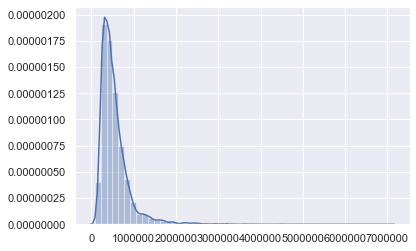

In [30]:
sns.distplot(y_train);

# predictions have to be de-logged afterwards

#Values are skewed to left or negative side

### View log of y_train

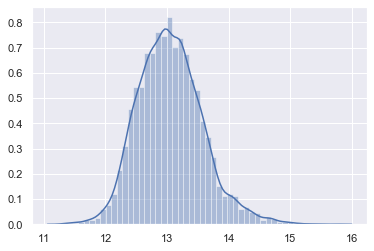

In [32]:
sns.distplot(np.log(y_train));

# This looks much more normal, log of y_train will be used for model

y_train = np.log(y_train)

### View initial regression

In [33]:
# Fit a multiple linear regression to the X and y train data
og_model, results = onetime_ols(X_train, y_train)
results_as_html = results.tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
results_df = results_df.reset_index()
results_df = results_df.rename(columns={'index':'feature'})

# Review P>|t| values from generated results_df
results_df

# Review r2 adjusted and other statistical results with the full summary
onetime_ols(X_train, y_train);

### Generate seaborn visualization

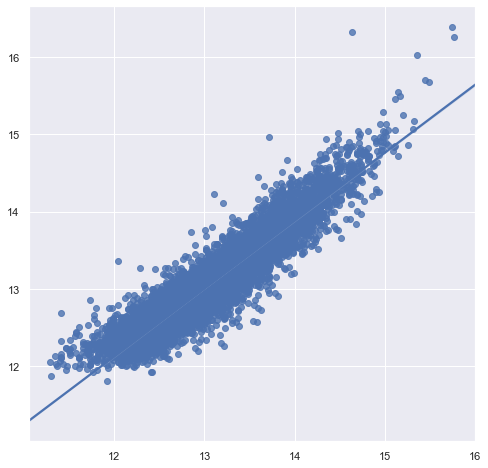

In [39]:
# Generate predicted prices from model
y_pred = og_model.predict()

# Plot predicted values
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(8, 8))

tr = sns.regplot(x=y_train, y=y_pred);

# xlabels = ['{:,.0f}'.format(x) + '' for x in tr.get_xticks()/1]
# ylabels = ['{:,.0f}'.format(y) + '' for y in tr.get_xticks()/1]
tr.set_xticklabels(xlabels);
tr.set_yticklabels(ylabels);

# ## Look at the residuals as well, yellowbrick package for residual plots
# ### y_train - y_pred on y and then y_train on x axis

In [42]:
r2adj = og_model.rsquared_adj
print('Model\'s R2 adjusted value equals {}'.format(r2adj))

Model's R2 adjusted value equals 0.8777970211775705


### View initial residual plot

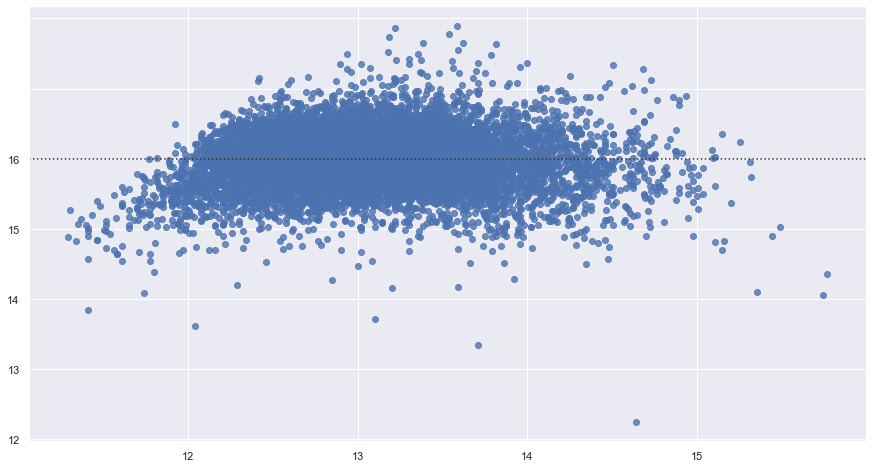

In [46]:
# Define x and y axis
xax = y_train
yax = y_train - y_pred

# Create sns graph
sns.set(style="darkgrid")   
fig, ax = plt.subplots(figsize=(15, 8))

resid = sns.residplot(x=xax, y=yax);

# xlabels = ['{:,.0f}'.format(x) + '' for x in resid.get_xticks()/1]
# ylabels = ['{:,.0f}'.format(y) + '' for y in resid.get_xticks()/1]
resid.set_xticklabels(xlabels);
resid.set_yticklabels(ylabels);